In [1]:
import numpy as np
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
import cv2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv('WordDifficulty.csv')
print(data.isnull().sum())  
data = data.dropna()
data['I_Zscore']=MinMaxScaler().fit_transform(data['I_Zscore'].values.reshape(-1,1))

Word                1
Length              0
Freq_HAL            0
Log_Freq_HAL        0
I_Mean_RT          13
I_Zscore           13
I_SD               31
Obs                13
I_Mean_Accuracy     0
dtype: int64


In [3]:
# text = ' '.join(data["Word"].sample(np.round(data.shape[0]/2).astype(int)))
# wordcloud = WordCloud(
#     background_color="white", 
#     min_font_size=0.01,
#     colormap='gist_rainbow_r')
    
# wordcloud.generate(text)



# plt.figure(figsize=(10, 10))
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

In [4]:
# text_hardest = ' '.join(data['Word'][data.sort_values('I_Zscore',ascending=False).index][0:10].values)
# text_easiest = ' '.join(data['Word'][data.sort_values('I_Zscore',ascending=True).index][0:10].values)
# print('The hardest words are: ',text_hardest,'\n')
# print('The easiest words are: ',text_easiest,'\n')

In [5]:
# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,9))

# wordcloud = WordCloud(
#         background_color="white", 
#         min_font_size=4,
#         colormap='jet',
#         height=1000,
#         width=1000
#         )
# wordcloud.generate(text_hardest)

# ax1.imshow(wordcloud)
# ax1.axis("off")
# ax1.set_title('Hardest words')

# wordcloud.generate(text_easiest)

# ax2.imshow(wordcloud)
# ax2.axis("off")
# ax2.set_title('Easiest words')

# plt.show()

In [6]:
columns = ['I_Mean_RT', 'I_SD', 'Log_Freq_HAL', 'Length']

# Loop through each column and filter out outliers using IQR
for column in columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
z_threshold = 3

# Loop through each column and filter out outliers using Z-score
for column in columns:
    z_scores = (data[column] - data[column].mean()) / data[column].std()
    data = data[(z_scores < z_threshold) & (z_scores > -z_threshold)]
data['label'] = (data['I_Mean_Accuracy'] < 0.80).astype(int)


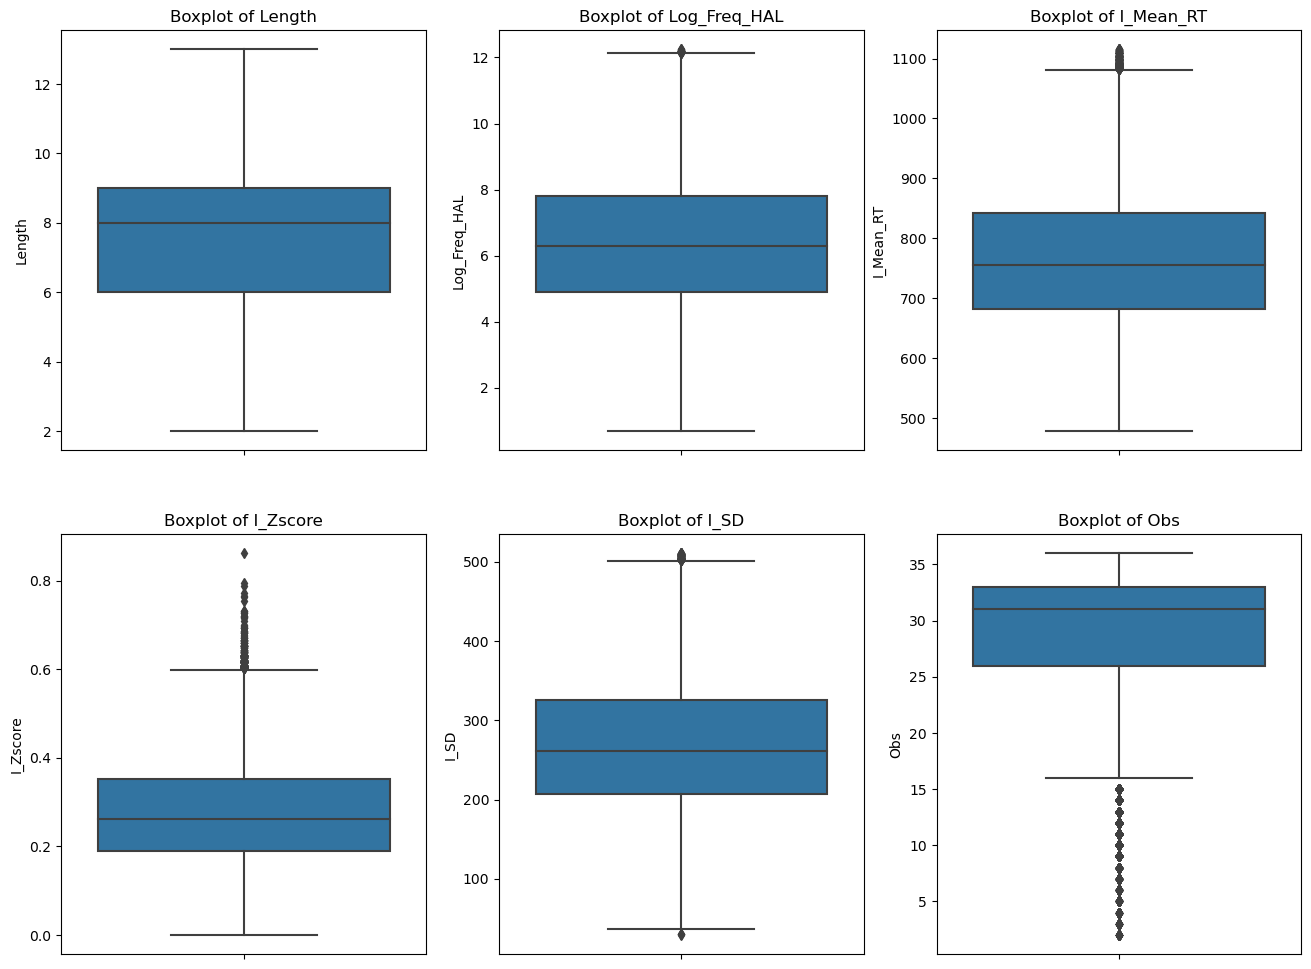

In [7]:
features = ['Length', 'Log_Freq_HAL', 'I_Mean_RT', 'I_Zscore', 'I_SD', 'Obs']
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=data[feature])
    plt.title(f'Boxplot of {feature}')

In [8]:
X = data[features] 
y = data['label']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# scaler = StandardScaler()

# # Fit the scaler to the training data and transform it
# X_train_scaled = scaler.fit_transform(X_train)

# # Apply the same transformation to the test data
# X_test_scaled = scaler.transform(X_test)


In [10]:
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)


In [11]:
print(data.isnull().sum())  # Should show all zeros now


Word               0
Length             0
Freq_HAL           0
Log_Freq_HAL       0
I_Mean_RT          0
I_Zscore           0
I_SD               0
Obs                0
I_Mean_Accuracy    0
label              0
dtype: int64


In [13]:
from sklearn.model_selection import RandomizedSearchCV
import time


# Define the parameter distribution
param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=gbm,
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    scoring='accuracy',
    cv=5,
    verbose=3,
    random_state=42,
    n_jobs=-1
)

# Track time and progress
start_time = time.time()
print("Starting RandomizedSearchCV...")
random_search.fit(X_train, y_train)
end_time = time.time()

# Print the total time taken
print(f"RandomizedSearchCV completed in {end_time - start_time:.2f} seconds.")

# Print the best parameters and evaluation metrics
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

best_gbm = random_search.best_estimator_
y_pred = best_gbm.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Starting RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomizedSearchCV completed in 54.41 seconds.
Best Parameters: {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 2, 'learning_rate': 0.2}
Best Cross-Validation Score: 0.9712677921218139
Test Accuracy: 0.9702105123791871
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      5694
           1       0.94      0.94      0.94      1859

    accuracy                           0.97      7553
   macro avg       0.96      0.96      0.96      7553
weighted avg       0.97      0.97      0.97      7553



In [14]:
# y_pred = gbm.predict(X_test)

In [15]:
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy}')
# print('Classification Report:')
# print(classification_report(y_test, y_pred))

In [16]:
# new_word_features = [[1,16.18, 798.92, -0.01, 333.85, 24]]  
# predicted_label = gbm.predict(new_word_features)
# print(f'The word is predicted to be {"hard" if predicted_label[0] == 1 else "easy"}')
frequency_data =  pd.read_csv('WordFrequency.csv')

In [17]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")



# Function to compute features for a new word
def compute_features(new_word, frequency_df, mean_rt, mean_sd):
    length = len(new_word)
    
    
    freq_hal = frequency_df.set_index('word')['count'].get(new_word, 1)
    log_freq_hal = np.log(freq_hal) if freq_hal > 0 else 1  

    zscore = 0  
    obs = 1  
    
    return [length, log_freq_hal, mean_rt, zscore, mean_sd, obs]


def predict_word_difficulty(new_word):
    
    if len(new_word) == 1:
        return "easy"
    
    if new_word in data['Word'].values:
       
        word_data = data[data['Word'] == new_word]
        word_features = word_data[features].values[0]
    else:
       
        mean_rt = data['I_Mean_RT'].mean()
        mean_sd = data['I_SD'].mean()
        word_features = compute_features(new_word, frequency_data, mean_rt, mean_sd)
    
    
    predicted_label = best_gbm.predict([word_features])
    
    
    freq_hal = frequency_data.set_index('word')['count'].get(new_word, 1)
    if freq_hal > frequency_data['count'].quantile(0.95) or len(new_word) <= 3:
        return "easy"
    
    return "hard" if predicted_label[0] == 1 else "easy"

# Function to predict difficulty for a paragraph
def predict_paragraph_difficulty(paragraph):
    
    words = re.findall(r'\b\w+\b', paragraph.lower())  
    
    word_difficulties = {}
    for word in words:
        difficulty = predict_word_difficulty(word)
        word_difficulties[word] = difficulty

    return word_difficulties

# Load datasets
data = pd.read_csv('WordDifficulty.csv').dropna()
frequency_data = pd.read_csv('WordFrequency.csv')

# Example paragraph input
paragraph = """important or momentous in our lives then?
The building of the boat was an important influence for me in monday another way. It
brought Ahmed Jalalluddin into my life. He was much older than me, yet we
struck up a friendship. He recognized the inherent desire within me to learn and
question, and was always there to lend a patient ear and give words of advice.
He could read and write English, and spoke to me about scientists and
inventions, literature and medicine. Walking with him in the streets of
Rameswaram, or by the seaside, or by our boat as it took shape, my mind began
to form ideas and ambitions onomatopoeia .
The boat business was a great success. My father employed some men to
operate it, and groups of pilgrims would use the service to reach Dhanushkodi.
There were days when I would slip in among the crowd and sit with the crew as
they steered the boat to and from Rameswaram. I heard the story of Rama and
how he built the bridge to Lanka with the help of his army of monkeys; how he
brought back Sita and stopped at Rameswaram again, so that they could perform
penance for having killed Ravana; how Hanuman was told to bring back a large
lingam from far up north, but when he took too long, Sita would not wait and
fashioned a lingam with her own hands to worship Shiva. These stories and
many others washed around me in different tongues and shapes, as people from
all over India used our ferry service. A little boy among so many was always
welcome and there would be someone or the other willing to talk to me, share
the story of his life and his reasons for making the pilgrimage.
And so the years went by. My school, teachers, Ahmed Jalalluddin and
others taught me so many things. But the boat and the people who sailed in it
were no less important. In this way, among the waves and the sands, laughter
and stories, the days flew by. Then one day, disaster struck.
The Bay of Bengal is hit frequently by cyclones. The months of November
and May in particular are dangerous in this regard. I still remember the night of
that terrible cyclone vividly. The wind had picked up speed for days, till it
became a howling gale. It screamed and whistled in our ears and pulled and
hacked at the trees or anything that stood in its way. Soon torrential rain started.
We had retreated into our houses much earlier. There was no electricity in those
days, and the lamps barely managed to stay alive. In that flickering darkness,
with the wind working itself into a frenzy, the sound of the rain lashing down
outside, we huddled together and waited for the night to pass. My thoughts
travelled again and again to the open seas. Was anyone trapped there? What was
it like to be in a storm such as this without your mother's comforting presence
close by?
The next morning, after the storm died down, we saw the unbelievable"""


word_difficulties = predict_paragraph_difficulty(paragraph)


for word, difficulty in word_difficulties.items():
    print(f'Word: "{word}", Difficulty: {difficulty}')


Word: "important", Difficulty: easy
Word: "or", Difficulty: easy
Word: "momentous", Difficulty: easy
Word: "in", Difficulty: easy
Word: "our", Difficulty: easy
Word: "lives", Difficulty: easy
Word: "then", Difficulty: easy
Word: "the", Difficulty: easy
Word: "building", Difficulty: easy
Word: "of", Difficulty: easy
Word: "boat", Difficulty: easy
Word: "was", Difficulty: easy
Word: "an", Difficulty: easy
Word: "influence", Difficulty: easy
Word: "for", Difficulty: easy
Word: "me", Difficulty: easy
Word: "monday", Difficulty: easy
Word: "another", Difficulty: easy
Word: "way", Difficulty: easy
Word: "it", Difficulty: easy
Word: "brought", Difficulty: easy
Word: "ahmed", Difficulty: easy
Word: "jalalluddin", Difficulty: hard
Word: "into", Difficulty: easy
Word: "my", Difficulty: easy
Word: "life", Difficulty: easy
Word: "he", Difficulty: easy
Word: "much", Difficulty: easy
Word: "older", Difficulty: easy
Word: "than", Difficulty: easy
Word: "yet", Difficulty: easy
Word: "we", Difficulty: 

In [22]:
import joblib

# Save the trained model to a file
joblib.dump(best_gbm, 'trained_gbm_model.pkl')

['trained_gbm_model.pkl']

In [18]:
train_accuracy = accuracy_score(y_train, best_gbm.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Training Accuracy: 0.9721615359152599
Test Accuracy: 0.9702105123791871
